In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import dask
import glob
import os
import warnings
import time as timer

In [2]:
dayspersummer = 92
daysperyear =  365

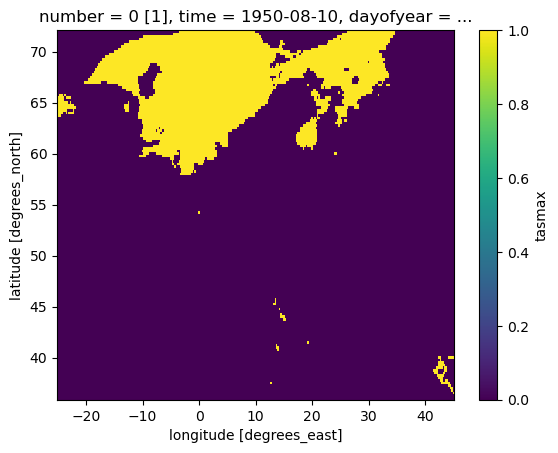

In [3]:
heatwaves = xr.open_dataset('~/Internship/ERA5_heatwave_array.nc').sel(time=slice('1940-06-01', '2014-08-31'))
heatwaves['tasmax'].isel(time = 1000).plot()

In [4]:
ERA5_mask = xr.open_dataset('~/ERA5_lsm_NH.nc')
ERA5_mask = ERA5_mask.rename({
    "longitude": "lon",
    "latitude": "lat",
    "time": "valid_time"
})

In [5]:
ERA5_mask = ERA5_mask.sel(lon=slice(-25,45), lat=slice(72, 36))
print(ERA5_mask)
land_mask_binary = xr.where(ERA5_mask > 0, 1, 0) 
#land_mask_binary = land_mask_binary.assign_coords(lat=ERA5.lat, lon=ERA5.lon)

<xarray.Dataset> Size: 2MB
Dimensions:     (valid_time: 1, lon: 701, lat: 361)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 8B 2013-11-29
  * lon         (lon) float32 3kB -25.0 -24.9 -24.8 -24.7 ... 44.8 44.9 45.0
  * lat         (lat) float32 1kB 72.0 71.9 71.8 71.7 ... 36.3 36.2 36.1 36.0
Data variables:
    lsm         (valid_time, lat, lon) float64 2MB ...
Attributes:
    CDI:                       Climate Data Interface version 2.4.4 (https://...
    Conventions:               CF-1.6
    history:                   Thu Dec 05 14:39:18 2024: cdo sellonlatbox,-18...
    NCO:                       4.7.2
    nco_openmp_thread_number:  1
    CDO:                       Climate Data Operators version 2.4.4 (https://...


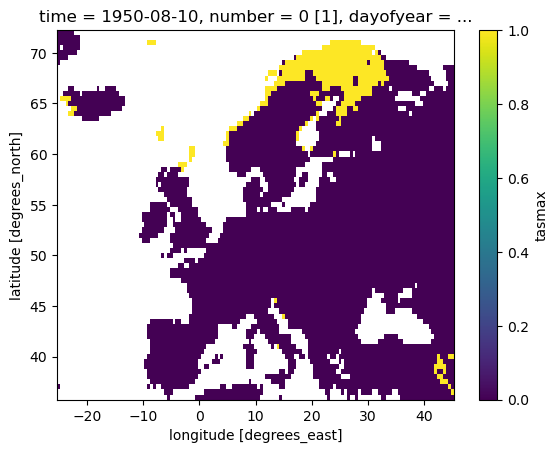

In [6]:
lsm = land_mask_binary['lsm']
land_hws = heatwaves.where(lsm == 1)
land_hws['tasmax'].isel(time = 1000).plot()

In [7]:
def heatwave_in_region(land_heatwaves, lat1, lat2):
    weights = np.cos(np.deg2rad(land_heatwaves['lat']))
    region = land_heatwaves.sel(lat = slice(lat1, lat2))
    region_avg = region.weighted(weights).mean(dim=('lat', 'lon'), skipna=True)
    percentile = region_avg.tasmax.quantile(0.9, dim="time", skipna=True)
    print(percentile)
    heatwave_in_region = (region_avg.tasmax > percentile)
    return heatwave_in_region

heatwave_in_europe = heatwave_in_region(land_hws, 72, 36)
heatwave_in_north = heatwave_in_region(land_hws, 72, 50)
heatwave_in_south = heatwave_in_region(land_hws, 50, 36)

ds_out = xr.Dataset(
    {
        "heatwave_in_europe": heatwave_in_europe,
        "heatwave_in_north": heatwave_in_north,
        "heatwave_in_south": heatwave_in_south
    }
)
#print(ds_out)
#ds_out.to_netcdf('ERA5_heatwave_in.nc')

<xarray.DataArray 'tasmax' (valid_time: 1)> Size: 8B
array([0.14368215])
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 8B 2013-11-29
    quantile    float64 8B 0.9
<xarray.DataArray 'tasmax' (valid_time: 1)> Size: 8B
array([0.1765933])
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 8B 2013-11-29
    quantile    float64 8B 0.9
<xarray.DataArray 'tasmax' (valid_time: 1)> Size: 8B
array([0.15712462])
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 8B 2013-11-29
    quantile    float64 8B 0.9


In [15]:
print(land_hws)

<xarray.Dataset> Size: 651MB
Dimensions:     (time: 7905, lat: 73, lon: 141, valid_time: 1)
Coordinates:
  * lat         (lat) float64 584B 72.0 71.5 71.0 70.5 ... 37.5 37.0 36.5 36.0
  * lon         (lon) float64 1kB -25.0 -24.5 -24.0 -23.5 ... 44.0 44.5 45.0
  * time        (time) datetime64[ns] 63kB 1940-06-01 1940-06-02 ... 2024-09-01
    number      int64 8B ...
    dayofyear   (time) int64 63kB ...
    quantile    float64 8B ...
  * valid_time  (valid_time) datetime64[ns] 8B 2013-11-29
Data variables:
    tasmax      (time, lat, lon, valid_time) float64 651MB 0.0 0.0 ... 0.0 0.0


<xarray.Dataset> Size: 259MB
Dimensions:     (time: 7905, lat: 29, lon: 141, valid_time: 1)
Coordinates:
  * lat         (lat) float64 232B 50.0 49.5 49.0 48.5 ... 37.5 37.0 36.5 36.0
  * lon         (lon) float64 1kB -25.0 -24.5 -24.0 -23.5 ... 44.0 44.5 45.0
  * time        (time) datetime64[ns] 63kB 1940-06-01 1940-06-02 ... 2024-09-01
    number      int64 8B ...
    dayofyear   (time) int64 63kB ...
    quantile    float64 8B ...
  * valid_time  (valid_time) datetime64[ns] 8B 2013-11-29
Data variables:
    tasmax      (time, lat, lon, valid_time) float64 259MB nan nan ... 0.0 0.0


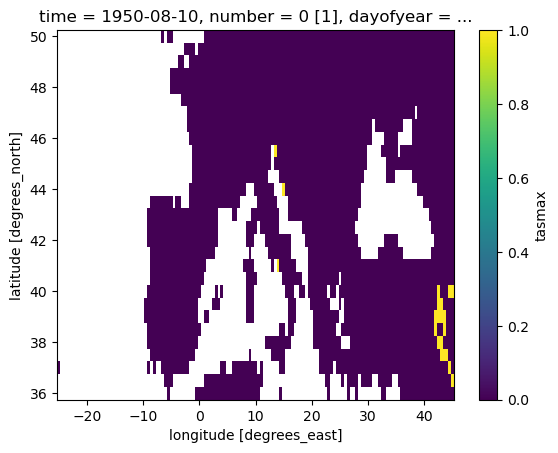

In [16]:
south = land_hws.sel(lat = slice(50, 36))
print(south)
south['tasmax'].isel(time = 1000).plot()

In [22]:
ein = xr.open_dataset('ERA5_heatwave_in.nc')
print(ein['heatwave_in_south'].values)

[[False]
 [False]
 [False]
 ...
 [ True]
 [ True]
 [False]]
